In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# currently (03/2019) scaleogram needs install via https://github.com/alsauve/scaleogram
# because an old PyWavelets (0.5.2) is installend and PyWavelets > 1.0 is needed
import scaleogram as scg 
import pywt

# choose default wavelet function for the entire notebook
scg.set_default_wavelet('cmor1-1.5')

# Try these ones to see various compromises between scales and time resolution 
#scg.set_default_wavelet('cgau5')
#scg.set_default_wavelet('cgau1')
#scg.set_default_wavelet('shan0.5-2')
#scg.set_default_wavelet('mexh')

Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


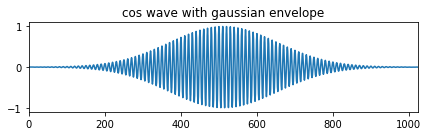

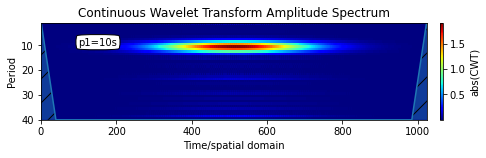

In [4]:
# let consider a timeline with 1 sample / second
ns = 1024
time = np.arange(ns)

# and a range of scales to perform the transform
scales = scg.periods2scales(np.arange(1, 40))

# and a periodic signal with varying amplitude
p1 = 10
periodic1 = np.cos(2*np.pi/p1*time) * np.exp(-((time-ns/2)/200)**2)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(6.2,2));  
lines = ax1.plot(periodic1); 
ax1.set_xlim(0, len(time))
ax1.set_title("cos wave with gaussian envelope")
fig1.tight_layout()

#scg.cws(periodic1, scales=scales, figsize=(6.9,2.3))
# and the scaleogram
ax2 = scg.cws(periodic1, scales=scales, figsize=(6.9,2.3))
txt = ax2.annotate("p1=10s", xy=(100, 10), bbox=dict(boxstyle="round4", fc="w"))
plt.tight_layout()

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

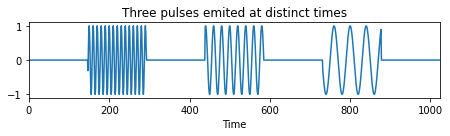

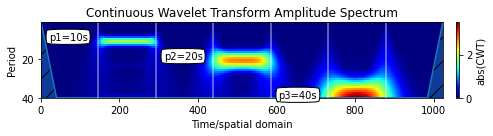

In [5]:
pulses = np.zeros(ns, dtype=np.float32)
steps  = np.linspace(0, ns, 8)
periods = [10, 20, 40]
for i in range(0,3):
    step_mask = (time > steps[i*2+1]) & (time < steps[i*2+2])
    pulses += np.cos(2*np.pi/periods[i]*time) * step_mask

# plot the pulses
fig1, ax1 = plt.subplots(1, 1, figsize=(6.5,2));  
lines = ax1.plot(pulses); ax1.set_xlim(0, len(time)); 
ax1.set_title("Three pulses emited at distinct times"); ax1.set_xlabel("Time")
fig1.tight_layout()

# and the scaleogram
ax2 = scg.cws(pulses, scales=scales, figsize=(7,2))

# add fancy helpers
for i in range(0, 3):
    txt = ax2.annotate("p%d=%ds"%(i+1,periods[i]), xy=(steps[i*2]+20, periods[i]), 
                       bbox=dict(boxstyle="round4", fc="w"))
    ax2.plot(steps[i*2+1]*np.ones(2), ax2.get_ylim(), '-w', alpha=0.5)
    ax2.plot(steps[i*2+2]*np.ones(2),   ax2.get_ylim(), '-w', alpha=0.5)
plt.tight_layout()

In [6]:
def psi(T, f0=6):
    '''
    T: parameter for adjusting length of wavelet
    f0: parameter for time-frequency resolution trade off
    '''
    x = np.linspace(-2*np.pi, 2*np.pi, T)
    return (np.pi ** -0.25) * np.exp(1j * f0 * x - x ** 2 / 2)

C:\Users\HYKP\miniconda3\envs\bistel\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


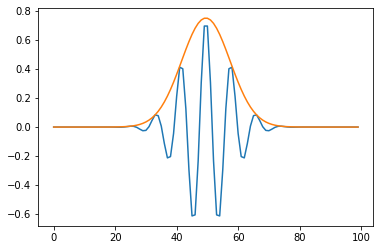

In [12]:
t100 = psi(100)
t200 = psi(200)

plt.plot(t100)
plt.plot(abs(t100))
#plt.plot(t200)
plt.show()

In [23]:
from scipy.fft import fft, ifft

def wavelet_conv(f, T):
    '''
    f : input signal
    T : length of wavelet
    '''
    
    f_len = np.shape(f)[0]
    f_hat = np.append(f, np.zeros(T))
    h = psi(T)
    h_hat = np.append(h, np.zeros(f_len))
    
    return ifft(fft(f_hat)*fft(h_hat))[round(T/2) : round(T/2) + f_len]